In [1]:
import pyms
import numpy as np
import torch


from pyms.utils.torch_utils import (
    amplitude,
    crop_to_bandwidth_limit_torch,
    size_of_bandwidth_limited_array,
    amplitude,
)

from pyms.Probe import (
    make_contrast_transfer_function,
)

crystal = pyms.structure.fromfile(
    "Structures/SrTiO3_CeO2_interface.xyz", atomic_coordinates="cartesian"
)

# A few maniupulations to remove vaccuum at edges and create a psuedo-periodic
# structure
crystal = crystal.resize([0.1, 0.76], axis=0)
from copy import deepcopy

other = deepcopy(crystal).resize([0.017, 0.99], axis=0)
other.reflect([0])
crystal = crystal.concatenate(other, axis=0)


# Quick plot of crystal
# crystal.quickplot(atomscale=1e-5)

# Subslicing of crystal for multislice
subslices = [0.33, 0.66, 1.0]

# Grid size in pixels
gridshape = [1024, 1024]

# Tile structure in multislice for a square grid
tiling = [1, 7]

# Probe accelerating voltage in eV
eV = 3e5

# Objective aperture in mrad
app = 15

# No aperture is also an option
# app = None

# Set up series of thicknesses
thicknesses = np.array([100])


In [2]:
from pyms.Probe import aberration

# Establish aberrations

df = 200.0 # 100 for later value, 200 to start so just changed 100 to 200

aberrations = []

# I've taken Cs from the 4D_STEM_Workshop demo
Cs = float(1.2e7)

# still need values for these, have default assumed zero but this might cause issues
A1 = 10.0 # changing this value to 100 and 1e8 had no effect so that isn't the problem
A2 = 10.0
B2 = 10.0
A3 = 10.0
S3 = 10.0
A4 = 10.0
D4 = 10.0
B4 = 10.0
C5 = 10.0
A5 = 10.0
S5 = 10.0
R5 = 10.0

#aberrations = pyms.Probe.aberration_starter_pack()

# Krivanek aberration coefficient, Haider aberration coefficient, colloquial name, amplitude, angle, n, m
# n and m are constants (shouldn't be differentiable), amplitude and angle should be

# Assuming angle for defocus is 0?

# focus on just getting one other aberration to work for now

aberrations.append(aberration("C10", "C1", "Defocus          ", df, 0.0, 1, 0))
aberrations.append(aberration("C12", "A1", "2-Fold astig.    ", A1, 0.0, 1, 0)) # changed angle to a value (5) but made no difference so changed i back to 0

# I've put all the angles as 0 and put variables for the amplitudes

aberrations.append(aberration("C23", "A2", "3-Fold astig.    ", A2, 0.0, 2, 3))
aberrations.append(aberration("C21", "B2", "Axial coma       ", B2, 0.0, 2, 1))
aberrations.append(aberration("C30", "C3", "3rd order spher. ", Cs, 0.0, 3, 0))

#aberrations.append(aberration("C34", "A3", "4-Fold astig.    ", A3, 0.0, 3, 4))
#aberrations.append(aberration("C32", "S3", "Axial star aber. ", S3, 0.0, 3, 2))

# temporarily removed some aberrations to hopefully make it run faster to check it works
#aberrations.append(aberration("C45", "A4", "5-Fold astig.    ", A4, 0.0, 4, 5))
#aberrations.append(aberration("C43", "D4", "3-Lobe aberr.    ", D4, 0.0, 4, 3))
#aberrations.append(aberration("C41", "B4", "4th order coma   ", B4, 0.0, 4, 1))
#aberrations.append(aberration("C50", "C5", "5th order spher. ", C5, 0.0, 5, 0))
#aberrations.append(aberration("C56", "A5", "6-Fold astig.    ", A5, 0.0, 5, 6))
#aberrations.append(aberration("C52", "S5", "5th order star   ", S5, 0.0, 5, 2))
#aberrations.append(aberration("C54", "R5", "5th order rosette", R5, 0.0, 5, 4))



defocus = torch.tensor([df], requires_grad = True)

df = torch.tensor([200.0])
# alternatively
#defocus = aberrations[0].amplitude


In [3]:
output = pyms.HRTEM(
    crystal,
    gridshape,
    eV,
    app,
    thicknesses,
    subslices=subslices,
    aberrations=aberrations, # may issue is here the A1 value has requires_gradient = True, whereas defocus is just a number?
    df=df,
    tiling=tiling,
    nfph=1,
    showProgress='notebook', 
    apply_ctf = False,
)

import matplotlib.pyplot as plt
%matplotlib inline
#plt.imshow(output)

print(output.size())

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

/home/hremadmin/py_multislice_differentiable/py_multislice_differentiable_tem/pyms/Premixed_routines.py:1518: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  for df_ in defocii


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([683, 683])


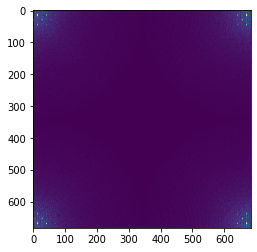

In [4]:
plt.imshow(torch.abs(output).detach().cpu().numpy(), vmax = 10)

In [5]:
path = '/home/hremadmin/Documents/Project/differentiable/df_200_test_data.npy'

ref_data = np.load(path)
ref_data = torch.tensor(ref_data).to('cpu') # change cuda to cpu

In [6]:
aberrations[1].amplitude.is_leaf
# Okay so its a leaf node so it should be differentiable??? check if in the loop is still differentiable

True

In [ ]:
bw_limit_size = size_of_bandwidth_limited_array(gridshape)
rsize = np.asarray(crystal.unitcell[:2]) * np.asarray(tiling)

params = [defocus, aberrations[1].amplitude] 
# even when defocus is removed, so should be optimising just the other aberration the value doesn't change. hmmm

optimizer = torch.optim.Adam(params, lr = 1e-1)
criterion = torch.nn.MSELoss()
n_iters = 2000


loss_curve = []
defocii_curve = []
A1_curve = []

#A2_curve = []
#B2_curve = []
#C3_curve = []


for iter in range(n_iters):
    #print(aberrations[1].amplitude.is_leaf) # True so should be differentiable
    ctf = (
            torch.stack(
                [
                    make_contrast_transfer_function(
                        bw_limit_size, rsize, eV, app, df=defocus, aberrations=[defocus, [aberrations[1].amplitude, 1, 0, 0]] #previously aberrations
                    )
                ]
            )
        .type(torch.complex128)
        .to('cpu') # changed cuda to cpu
    )

    sim_image = amplitude(torch.fft.ifftn(ctf * output, dim=(-2, -1))) # tried removing dimenions, no effect
    
    optimizer.zero_grad()
    
    loss = criterion(sim_image, ref_data)*1000000000
    # mentions that the sim_image and ref_data have different dimensions and highlights this as an issue
    # sim_image has size ([1, 83, 683]) andref_data has size ([683, 683])
    # dim(-2, -1) has no effect on this?

    loss.backward()

    optimizer.step()

    loss_curve.append(loss.item())
    defocii_curve.append(defocus.item())
    A1_curve.append(aberrations[1].amplitude.item())
    
    
    #A2_curve.append(aberrations[2].amplitude.item())
    #B2_curve.append(aberrations[3].amplitude.item())
    #C3_curve.append(aberrations[4].amplitude.item())

/home/hremadmin/miniconda3/envs/pyms_2/lib/python3.6/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([683, 683])) that is different to the input size (torch.Size([1, 683, 683])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
print(aberrations[1].amplitude)
# is not optimising this value even though its set-up in the same way as defocus- maybe in other parts of code?

print(defocus)

In [ ]:
plt.plot(loss_curve)

In [ ]:
plt.plot(defocii_curve)

In [ ]:
plt.plot(A1_curve)

In [ ]:
plt.imshow(sim_image[0].detach().cpu().numpy())